### Pose estimation evaluation metrics

This will be used to get an idea of how accurate YOLOv8 is at extracting the pose of the patient. 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import re


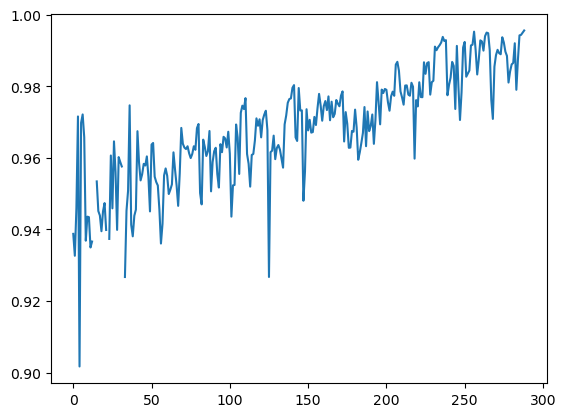

In [3]:
# Plotting the confidence score of YOLO in predicting the location of various keypoints:

pose_df = pd.read_csv("../Pose-Extractions/OAW08-bottom-front2.csv", index_col=0)

plt.figure()
plt.plot(pose_df.index, pose_df.LAnkle_conf)

In [6]:
video_dir = "../Videos/Cropped/OAW06/"

for video_name in os.listdir(video_dir):
    if video_name.endswith(".mp4"):
        video_path = os.path.join(video_dir, video_name)
        print(f"Video {video_name}:")
        
        # Converting random frames from the video to images, so they can be used for PCK
        cap = cv2.VideoCapture(video_path)
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        frame_i = random.sample(range(0, int(frame_count)), 3)

        for i in frame_i:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            success, image = cap.read()
            if success: 
                cv2.imwrite("temp_images/" + video_name[:-4] + f"-frame{i}.jpg", image)  
                print(f"Frame {i} converted to image.")

Video OAW06-bottom-back1.mp4:
Frame 231 converted to image.
Frame 141 converted to image.
Frame 284 converted to image.
Video OAW06-bottom-back2.mp4:
Frame 303 converted to image.
Frame 251 converted to image.
Frame 131 converted to image.
Video OAW06-bottom-front1.mp4:
Frame 328 converted to image.
Frame 87 converted to image.
Frame 206 converted to image.
Video OAW06-bottom-front2.mp4:
Frame 166 converted to image.
Frame 146 converted to image.
Frame 136 converted to image.
Video OAW06-bottom-front3.mp4:
Frame 134 converted to image.
Frame 120 converted to image.
Frame 53 converted to image.
Video OAW06-top-back1.mp4:
Frame 124 converted to image.
Frame 157 converted to image.
Frame 119 converted to image.
Video OAW06-top-back2.mp4:
Frame 289 converted to image.
Frame 146 converted to image.
Frame 179 converted to image.
Video OAW06-top-front1.mp4:
Frame 215 converted to image.
Frame 54 converted to image.
Frame 31 converted to image.
Video OAW06-top-front2.mp4:
Frame 12 converted to

In [3]:
# code modified from https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/

# list of body keypoints I will be collecting	
keypoints = [
    "RAnkle",
	"LAnkle",
	"RKnee",
	"LKnee",
	"RHip",
	"LHip",
	"RShoulder"
]

# function to display the coordinates of of the points clicked on the image 
def click_event(event, x, y, flags, params):
	global current_kp_index 

	# checking for left mouse clicks 
	if event == cv2.EVENT_LBUTTONDOWN: 

		clicks[f"{keypoints[current_kp_index]}_x"] = x
		clicks[f"{keypoints[current_kp_index]}_y"] = y

		# displaying the coordinates on the Shell 
		print(x, ' ', y) 

		# displaying the coordinates on the image window 
		font = cv2.FONT_HERSHEY_SIMPLEX 
		# cv2.putText(img, str(x) + ',' + str(y), (x,y), font, 1, (255, 0, 0), 2) 

		# displaying the keypoint number on the image window
		cv2.putText(img, str(current_kp_index + 1), (x,y), font, 1, (255, 0, 0), 2) 
		
		# draw a circle at the click location
		cv2.circle(img, (x, y), 5, (0, 255, 0), -1)

		# check if there are more prompts
		if current_kp_index < len(keypoints) - 1:
			current_kp_index += 1
			display_prompt(img)
		else:
			cv2.putText(img, "All points collected.", (10, 30), font, 0.7, (0, 255, 0), 2)
			cv2.imshow('image', img)


def display_prompt(image):
    prompt = keypoints[current_kp_index]
    img_with_prompt = image.copy()
    cv2.putText(img_with_prompt, prompt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.imshow('image', img_with_prompt)


def extract_frame_num(im_name):
	# regular expression to extract the number before '.jpg'
	p = r'frame(\d+)\.jpg$'

	return re.search(p, im_name).group(1)


def extract_file_name(im_name):
	# regular expression to extract the string before '-frame' and '.jpg'
	p = r'^(.*)-frame\d+\.jpg$'

	return re.search(p, im_name).group(1) + ".mp4"


if __name__=="__main__": 

	img_directory = 'temp_images'
	output = pd.DataFrame()

	for img_name in os.listdir(img_directory):
		if img_name.endswith(('.png', '.jpg', '.jpeg')):
			img_path = os.path.join(img_directory, img_name)

            # Reading the image
			img = cv2.imread(img_path, 1)
			# img = cv2.resize(img, (int(1080/2), int(1920/2))) # resizing as original size too big to view on monitor

            # initialize the current keypoint index and clicks dictionary
			current_kp_index = 0

			clicks = {f"{name}_x": 0 for name in keypoints}
			clicks.update({f"{name}_y": 0 for name in keypoints})
			clicks["file_name"] = extract_file_name(img_name)
			clicks["frame"] = extract_frame_num(img_name)
			

            # display the initial prompt
			display_prompt(img)

            # setting mouse handler for the image and calling the click_event() function
			cv2.setMouseCallback("image", click_event)

            # wait for a key to be pressed to exit
			key = cv2.waitKey(0)
			if key == ord("2"):
				# resizing as original size too big to view on monitor
				img = cv2.resize(img, (int(1080/2), int(1920/2))) 
				display_prompt(img)
				cv2.waitKey(0)
				
				# multiplying all values in the df by 2 to account for the resizing prior to annotation
				clicks = {key: (value * 2 if isinstance(value, int) else value) for (key, value) in clicks.items()}

			cv2.destroyAllWindows()

			output = pd.concat([output,  pd.DataFrame([clicks])], ignore_index=True)

	# multiplying all values in the df by 2 to account for the resizing prior to annotation
	# output = output.applymap(lambda x: x * 2 if isinstance(x, int) else x)

	output.to_csv(f"../Keypoint-Annotations/{img_name[:5]}.csv")


624   640
595   656
629   543
592   555
642   449
589   448
660   323
639   524
618   533
642   460
616   461
652   387
615   386
663   302
635   493
617   481
638   428
615   426
648   367
621   366
661   288
644   739
609   708
654   615
612   611
673   488
606   485
696   344
652   543
631   532
659   472
627   472
668   400
632   395
684   302
659   485
637   502
659   433
636   437
664   371
633   371
676   291
628   663
654   627
627   559
667   557
619   462
677   461
607   330
346   610
368   555
350   499
379   494
339   393
409   390
324   235
616   499
634   505
613   442
636   444
611   381
644   381
598   295
616   563
637   557
620   490
644   490
617   416
657   411
606   309
620   570
642   557
619   495
652   497
615   424
659   420
602   308
631   604
649   596
637   516
662   519
627   431
676   433
621   315
605   530
624   523
604   465
634   469
599   398
640   394
590   300
603   522
629   550
607   472
636   478
606   406
647   403
599   304
589   482
611   487


### PDJ - Percentage of Detected Joints 

Calculated by finding the torso diameter (diagonal from shoulder to hip), then checking if the distance from the true keypoint to the predicted keypoint is < 0.2 * torso diameter

In [16]:
import tkinter
from tkinter import filedialog
from scipy.spatial import distance

keypoints = [
    "RAnkle",
	"LAnkle",
	"RKnee",
	"LKnee",
	"RHip",
	"LHip"
]

def calculate_pdj_thold(row):
    # calculate the PDJ threshold = 0.2 * torso diameter (distance from left hip to right shoulder)
    
    torso_diameter = distance.euclidean(row[["RShoulder_x", "RShoulder_y"]], row[["LHip_x", "LHip_y"]]) # distance from left hip to right shoulder
    return torso_diameter * 0.2

def find_prediction(row):
    # for 
    pred_path = f"../Pose-Extractions/{row['file_name'][:-4]}.csv"
    pred_df = pd.read_csv(pred_path, index_col=0)

    return pred_df.loc[int(row["frame"])]


def calculate_kp_distances(row, kp):
    return distance.euclidean(row[[f"{kp}_x", f"{kp}_y"]], row[[f"{kp}_x_p", f"{kp}_y_p"]])


def calculate_kp_detected(row, kp):
    if row[f"{kp}_distance"] < row["PDJ_thold"]:
        return 1
    else:  
        return 0


if __name__=="__main__": 
    # load annotation file
    tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing
    pose_labels_path = filedialog.askopenfilename()
    labels_df = pd.read_csv(pose_labels_path, index_col=0)

    # create a df of the predictions that correspond to each row in the annotation df
    pred_df = pd.DataFrame()
    pred_df = labels_df.apply(find_prediction, axis=1)

    # add the two dfs together
    pred_df = pred_df.rename(columns=lambda x: x + '_p') # distinguish between annotation and prediction columns
    df = pd.concat([labels_df, pred_df], axis=1)

    # calculate the PDJ threshold for each frame in the annotation file
    df["PDJ_thold"] = labels_df.apply(calculate_pdj_thold, axis=1)

    # calculate the distance between the predicted and true kp location
    for kp in keypoints:
        df[f"{kp}_distance"] = df.apply(lambda x: calculate_kp_distances(x, kp), axis=1)
        df[f"{kp}_detected"] = df.apply(lambda x: calculate_kp_detected(x, kp), axis=1)
        print(f'The PDJ for the {kp} is {len(df[df[f"{kp}_detected"] == 1]) / len(df[f"{kp}_detected"]) * 100}')
    

The PDJ for the RAnkle is 73.33333333333333
The PDJ for the LAnkle is 66.66666666666666
The PDJ for the RKnee is 70.0
The PDJ for the LKnee is 70.0
The PDJ for the RHip is 63.33333333333333
The PDJ for the LHip is 63.33333333333333


In [20]:
df[["LHip_distance", "LHip_detected"]]

,LHip_distance,LHip_detected
0,3.352660,1
1,2.828070,1
2,NaN,0
3,9.774887,1
4,41.189245,0
5,4.460868,1
6,54.371029,0
7,37.494019,1
8,5.572246,1
9,7.681135,1
